In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
%matplotlib inline

In [2]:
22%15

7

In [3]:
L = 100 # Длина основания
H = 150 # Высота всей детали
R = 10  # Радиусы малых окружностей
RR = 70 # Радиус большой окружности
W = 10  # Толщина стенки

In [4]:
def split_border(nodes, n, closed_contour=False):
    result = np.array([])
    
    ln = nodes.shape[0]-1
    
    for i in range(nodes.shape[0]-1):
        res_xs = np.linspace(nodes[i,0], nodes[i+1,0], n)[:-1]
        res_ys = np.linspace(nodes[i,1], nodes[i+1,1], n)[:-1]
        result = np.append(result, np.hstack((np.array(res_xs).reshape(-1,1), np.array(res_ys).reshape(-1,1))))

    if not closed_contour and n:
        result = np.append(result, np.hstack((np.array(nodes[:,0][-1]).reshape(-1,1), np.array(nodes[:,1][-1]).reshape(-1,1))))
        
    return result.reshape(-1, 2)

In [5]:
def gen_arc(center, R, alpha1, alpha2, n):
    alpha1 = np.radians(np.linspace(alpha1, alpha2, n))

    x1 = R * np.cos(alpha1) + center[0]
    y1 = R * np.sin(alpha1) + center[1]
    
    return np.hstack((x1.reshape(-1, 1), y1.reshape(-1, 1)))

In [6]:
def len_poly(poly):
    return np.sum(np.linalg.norm(poly[:-1]-poly[1:], axis=1))

In [7]:
def circular_mask(inner, circ_center, radius, delta=0):
    """True for points outside the circle"""
    mask = np.sum(np.power(inner - circ_center, 2), axis=1) > np.power(radius+delta, 2)
    return mask

In [8]:
def rectangular_mask(inner, lower_end_pt, h, w, delta=0):
    """True for points outside the rectangle"""
    mask = (inner[:,0] > lower_end_pt[0]+delta) & (inner[:,0] < lower_end_pt[0]+w-delta) &\
           (inner[:,1] > lower_end_pt[1]+delta) & (inner[:,1] < lower_end_pt[1]+h-delta)
    return np.logical_not(mask)

In [9]:
def transition_mask_upper(inner, big_radius, big_circle_center, small_radius, 
                    small_circle_center_left, small_circle_center_right, lower_plane_y, width):
    
    mask1 = circular_mask(inner, big_circle_center, big_radius+width)
    mask2 = circular_mask(inner, small_circle_center_left, small_radius)
    mask3 = circular_mask(inner, small_circle_center_right, small_radius)
    mask4 = (inner[:,0] > small_circle_center_left[0]) & (inner[:,0] < small_circle_center_right[0])
    mask5 = inner[:,1] > lower_plane_y
    
    return mask1 & mask2 & mask3 & mask4 & mask5

def transition_mask_lower(inner, small_circle_radius, small_circle_center_left, 
                          small_circle_center_right, lower_plane_y, upper_plane_y):
    mask1 = circular_mask(inner, small_circle_center_left, small_circle_radius)
    mask2 = circular_mask(inner, small_circle_center_right, small_circle_radius)
    mask3 = (inner[:,0] > small_circle_center_left[0]) & (inner[:,0] < small_circle_center_right[0])
    mask4 = (inner[:,1] > lower_plane_y) & (inner[:,1] < upper_plane_y)
    
    return mask1 & mask2 & mask3 & mask4

In [18]:
def construct_figure(W, R, cm_per_split=2):
    SPLITS_COEFF = 1./cm_per_split
    
    # ----> Constants <-----
    L = 100 # Длина основания
    H = 150 # Высота всей детали
    RR = 70 # Радиус большой окружности
    
    circ_big = np.array([0., 150])          # Inner and outer big circles
    circle_ll = np.array([W/2. + R, W + R]) # Low left circle center
    circle_ul = np.array([R + W/2., 150. - np.sqrt((70.+W)**2 - (R+W/2.)**2) - R]) # Upper left circle center
    circle_ur = np.array([-1.*(R + W/2.), 150. - np.sqrt((70.+W)**2 - (R+W/2.)**2) - R]) # Upper right circle center
    circle_lr = np.array([-1*(W/2. + R), W+R]) # Lower right circle center
    
    # Введем также константы для длин окружностей
    theta = np.rad2deg(np.arcsin((R+W/2.)/(RR+W)))
    upper_circle_len = (2.*np.pi*RR)/2.
    small_circles_len = (2.*np.pi*R)/4.
    lower_circles_len = (np.pi * (RR+W) * (90. - theta))/180.
    
    # ----> Create border <-----
    border_part1 = np.array([
        [-50, 0],
        [50, 0],
        [50, W],
        [W/2.+R, W]
    ], dtype=float)
    circ1 = gen_arc(circle_ll, R, 270, 180, int(small_circles_len*SPLITS_COEFF))[1:-1] # Except first and last point
                                                                # because we have border points there
    border_part2 = np.array([
        [W/2., W+R],
        [W/2, circle_ul[1]]
    ], dtype=float)
    circ2 = gen_arc(circle_ul, R, 180, 90, int(small_circles_len*SPLITS_COEFF))[1:-1] # Except first and last point
                                                               # because we have border and other arc points there
    circ3_alpha1 = theta
    circ3 = gen_arc(circ_big, RR+W, 270+circ3_alpha1, 360., int(lower_circles_len*SPLITS_COEFF))[:-1] # Except only last point because
                                                                            # we threw away last point of the previous arc

    border_part3 = np.array([
        [RR+W, H],
        [RR, H]
    ])

    circ4 = gen_arc(circ_big, RR, 360, 180, int(upper_circle_len*SPLITS_COEFF))[1:-1]

    border_part4 = np.array([
        [-1.*RR, H],
        [-1*RR-W, H]
    ])

    circ5 = gen_arc(circ_big, RR+W, 180, 270-circ3_alpha1, int(lower_circles_len*SPLITS_COEFF))[1:-1]

    circ6 = gen_arc(circle_ur, R, 90, 0, int(small_circles_len*SPLITS_COEFF))[:-1]

    border_part5 = np.array([
        [-1*W/2., circle_ur[1]],
        [-1*W/2., W+R]
    ])

    circ7 = gen_arc(circle_lr, R, 360, 270, int(small_circles_len*SPLITS_COEFF))[1:-1]

    border_part6 = np.array([
        [-1*(W/2.+R), W],
        [-50, W],
        [-50, 0.]
    ])
    
    # ----> Split border <-----
    # For border part1
    border_part1_sp_1 = split_border(border_part1[:2], int(L*SPLITS_COEFF))
    border_part1_sp_2 = split_border(border_part1[1:3], int(W*SPLITS_COEFF))
    border_part1_sp_3 = split_border(border_part1[2:], int((L/2. - R)*SPLITS_COEFF))
    border_part1_sp = np.vstack([border_part1_sp_1, border_part1_sp_2, border_part1_sp_3])

    border_part2_sp = split_border(border_part2, int(len_poly(border_part2)*SPLITS_COEFF))
    border_part3_sp = split_border(border_part3, int(W*SPLITS_COEFF))
    border_part4_sp = split_border(border_part4, int(W*SPLITS_COEFF))
    border_part5_sp = split_border(border_part5, int(len_poly(border_part5)*SPLITS_COEFF))

    # For border part6
    border_part6_sp_1 = split_border(border_part6[:2], int((L/2. - R)*SPLITS_COEFF))
    border_part6_sp_2 = split_border(border_part6[1:], int(W*SPLITS_COEFF))[:-1]
    border_part6_sp = np.vstack([border_part6_sp_1, border_part6_sp_2])
    
    border = np.vstack([border_part1_sp, circ1, border_part2_sp, circ2, circ3, border_part3_sp, circ4, border_part4_sp,
                circ5, circ6, border_part5_sp, circ7, border_part6_sp])
    
    # ----> Construct meshes <-----
    delta_x=0.5
    delta_y=2

    # Mesh for upper part
    mesh_upper = []
    for i in np.linspace(0, W, int(W*SPLITS_COEFF)):
        arc = gen_arc(circ_big, RR+i, 360, 180, int(upper_circle_len*SPLITS_COEFF))[1:-1]
        mesh_upper.append(arc)

    #arc_middle_fix = gen_arc(circ_big, RR+i, 270+theta-(R/5.), 270-theta+(R/5.), int((np.pi*(RR+W)*(2.*theta-10))/180.*SPLITS_COEFF))[1:-1]
    mesh_upper = mesh_upper[1:-1] # Throw away first and last arcs
    #mesh_upper.append(arc_middle_fix)
    mesh_upper = np.vstack(mesh_upper)

    # Mesh for lower part
    mesh_lower = []
    border_to_copy = border_part1[:2].copy()
    for i in np.linspace(0., circle_ur[1]+R, int((circle_ur[1]+R)*SPLITS_COEFF)):
        #border_to_copy += np.array([[0.,i],[0.,i]])
        mesh_lower.append(split_border(border_to_copy+np.array([[0.,i],[0.,i]]), int(L*SPLITS_COEFF))[1:-1])
    mesh_lower = mesh_lower[1:-2]
    mesh_lower = np.vstack(mesh_lower)

    inner = np.vstack([mesh_upper, mesh_lower])
    
    # ----> Masks for net <-----
    mask_delta = 1

    # For inner points inside big and bigger upper circles
    mask_big_circle = circular_mask(inner, circ_big, RR)
    mask_bigger_circle = circular_mask(inner, circ_big, RR+W)

    # For points inside transition areas and rectangle inbetween
    transition1 = transition_mask_upper(inner, RR, circ_big, R, circle_ur, circle_ul, circle_ul[1], W)
    transition2 = transition_mask_lower(inner, R, circle_lr, circle_ll, W, W+R)
    retangle_inbetween = rectangular_mask(inner, border_part5[-1], np.linalg.norm(border_part5[0] - border_part5[1]), W)

    # For points inside rectangular base
    rectangle_base = rectangular_mask(inner, [-1*L/2., 0.], W, L)

    # Construct resulting points
    inner_upper = inner[mask_big_circle & np.logical_not(mask_bigger_circle)]
    inner_lower = inner[transition1 | transition2 | np.logical_not(retangle_inbetween) | np.logical_not(rectangle_base)]
    inner_masked = np.vstack([inner_upper, inner_lower])
    
    Nodes = np.vstack((border, inner_masked))
    trng = scipy.spatial.Delaunay(Nodes)
    
    # ----> Masks for TRNG <-----
    trng_vertices = Nodes[trng.simplices.copy()]
    trng_x_vertices = trng_vertices[:, :, 0]
    trng_y_vertices = trng_vertices[:, :, 1]

    trng_x_mean = np.mean(trng_x_vertices, axis=1)
    trng_y_mean = np.mean(trng_y_vertices, axis=1)

    trng_centers = np.hstack((trng_x_mean.reshape(-1, 1), trng_y_mean.reshape(-1, 1)))

    simplices = trng.simplices.copy()

    # For inner points inside big and bigger upper circles
    mask_big_circle = circular_mask(trng_centers, circ_big, RR)
    mask_bigger_circle = circular_mask(trng_centers, circ_big, RR+W)

    # For points inside transition areas and rectangle inbetween
    transition1 = transition_mask_upper(trng_centers, RR, circ_big, R, circle_ur, circle_ul, circle_ul[1], W)
    transition2 = transition_mask_lower(trng_centers, R, circle_lr, circle_ll, W, W+R)
    retangle_inbetween = rectangular_mask(trng_centers, border_part5[-1], np.linalg.norm(border_part5[0] - border_part5[1]), W)

    # For points inside rectangular base
    rectangle_base = rectangular_mask(trng_centers, [-1*L/2., 0.], W, L)

    simplices1 = simplices[mask_big_circle & np.logical_not(mask_bigger_circle)]
    simplices2 = simplices[transition1 | transition2 | np.logical_not(retangle_inbetween) | np.logical_not(rectangle_base)]
    simplices = np.vstack([simplices1, simplices2])
    
    return Nodes, simplices

(-88.0, 88.0, -7.5, 157.5)

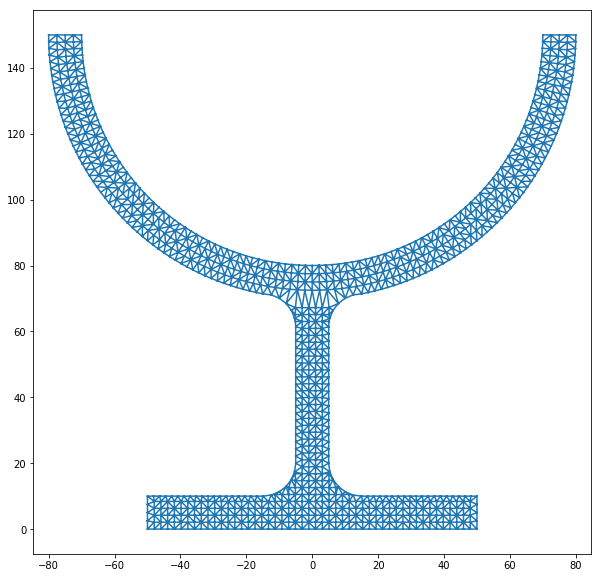

In [19]:
Nodes, simplices = construct_figure(10, 10)
plt.figure(figsize=(10, 10))
plt.triplot(Nodes[:, 0], Nodes[:, 1], simplices)
plt.axis('equal')

(-88.0, 88.0, -7.5, 157.5)

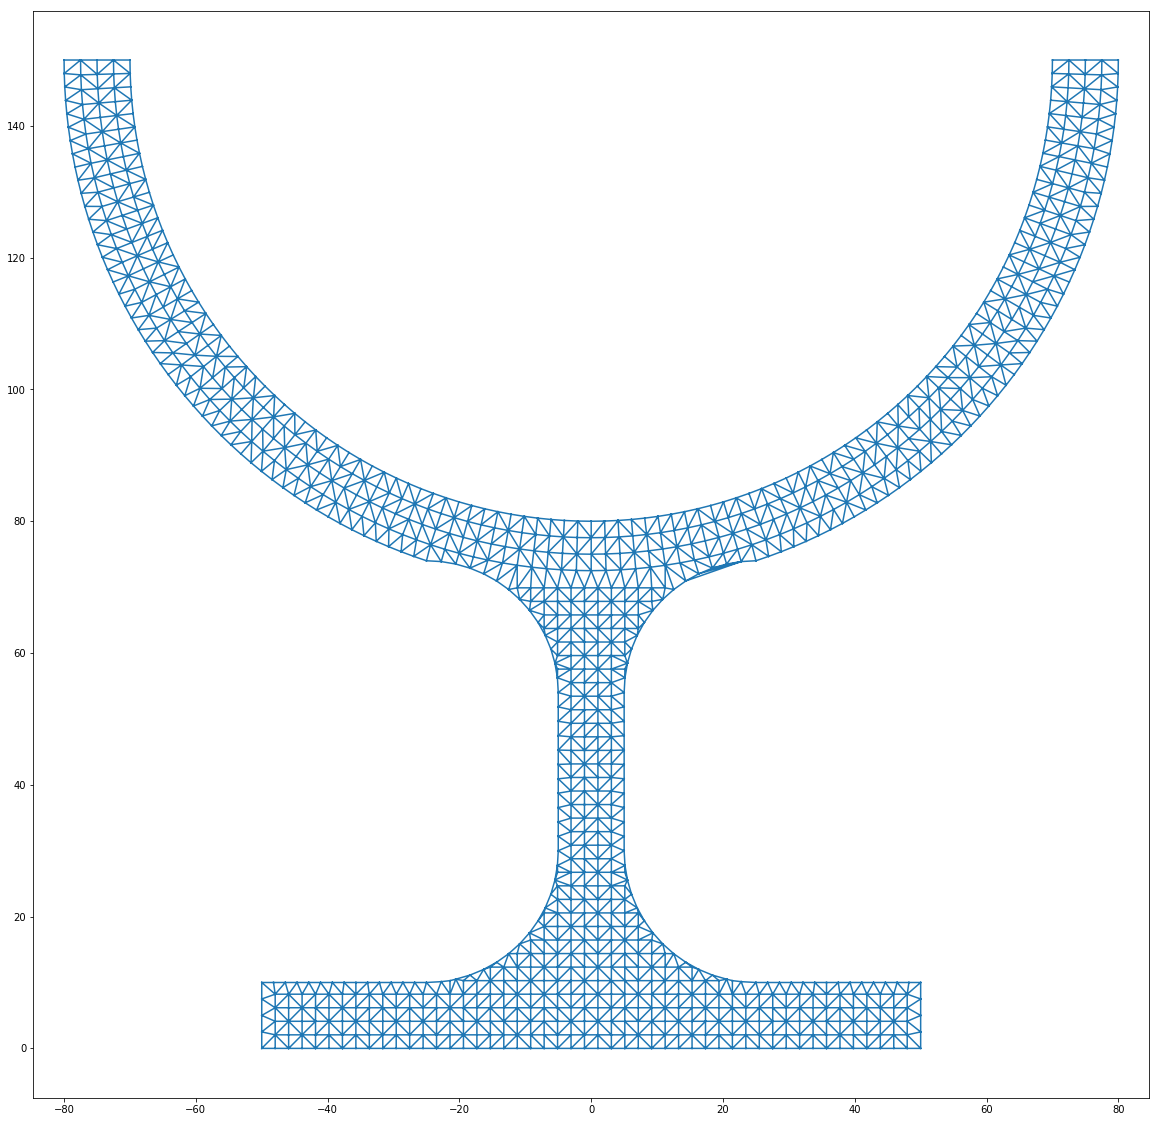

In [27]:
Nodes, simplices = construct_figure(10, 20)
plt.figure(figsize=(20, 20))
plt.triplot(Nodes[:, 0], Nodes[:, 1], simplices)
plt.axis('equal')

In [ ]:
circular_ma